In [1]:
!pip install facenet-pytorch requests Pillow

In [2]:
from datasets import load_dataset

celeb_faces = load_dataset('ashraq/tmdb-people-image', split='train')

In [3]:
celeb_faces

Dataset({
    features: ['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'image'],
    num_rows: 2000
})

In [4]:
metadata = celeb_faces.remove_columns(['adult', 'also_known_as', 'biography', 'birthday', 
                                       'deathday', 'gender', 'homepage', 'id', 'imdb_id', 
                                       'known_for_department', 'name', 'place_of_birth', 'popularity'])
metadata

Dataset({
    features: ['profile_path', 'image'],
    num_rows: 2000
})

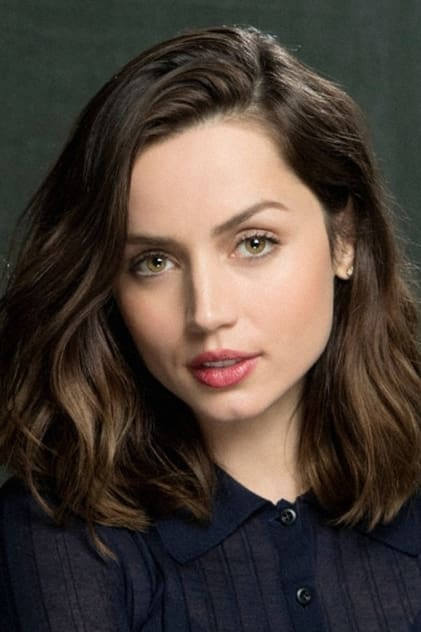

In [5]:
celeb_faces[13]['image']

In [6]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN()

imgs = celeb_faces['image'].copy()

In [78]:
boxes, prob = mtcnn.detect(imgs[13])
print(f'Bounding Box Coordinates {boxes}. \nProbability of detection {prob}')

Bounding Box Coordinates [[108.74130249023438 130.31378173828125 334.47552490234375
  420.5629577636719]]. 
Probability of detection [0.999588668346405]


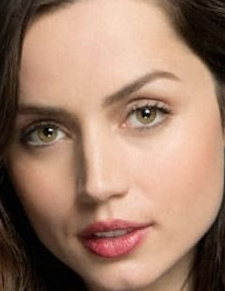

In [79]:
imgs[13].crop(boxes[0])

In [81]:
mtcnn(imgs[13]).shape

torch.Size([3, 160, 160])

In [84]:
from facenet_pytorch import InceptionResnetV1
import torch

resnet = InceptionResnetV1(pretrained='vggface2').eval()
embeddings = resnet(torch.stack([mtcnn(imgs[13])]))
embeddings          

tensor([[ 4.4950e-02, -5.6428e-02, -8.8877e-02, -6.5815e-02, -2.2462e-02,
         -3.3819e-03,  4.5344e-02,  2.6445e-02,  1.1577e-02,  5.5631e-02,
         -3.0906e-02,  1.8211e-02,  3.1784e-02, -7.0500e-02, -6.5971e-02,
         -1.0634e-01, -3.5236e-02,  1.0331e-03,  3.8834e-03,  3.0328e-02,
         -2.0395e-02,  5.4349e-02, -3.2565e-02,  3.8771e-04,  1.4539e-02,
          3.7905e-02, -2.9753e-02, -1.4720e-02, -2.9143e-02, -2.3280e-02,
          1.0444e-01, -8.2645e-03,  4.4023e-02, -1.1227e-02, -7.7203e-03,
          1.0956e-02, -7.1604e-02,  4.5801e-02,  3.2549e-02, -3.5475e-02,
         -2.7688e-02, -8.4280e-02,  2.7557e-02,  1.2788e-02, -8.5890e-03,
          4.2007e-02, -4.8430e-02, -1.0268e-02,  4.4615e-03, -8.3002e-02,
          1.0372e-01, -1.6352e-02,  2.0802e-02,  1.1432e-01,  2.0078e-02,
          4.9520e-02, -2.6773e-02,  6.3462e-02, -6.9467e-02, -4.2796e-02,
          6.1660e-03,  3.6656e-02, -5.5108e-02, -9.0602e-03, -5.8454e-02,
         -6.0253e-02,  3.4374e-02, -2.

In [201]:
import numpy as np

class ExtractFacialEmbeddings:
    def __init__(self):
        self.device = torch.device('cpu')
        self.mtcnn = MTCNN(device = self.device)
        self.resnet = InceptionResnetV1(pretrained='vggface2', device=self.device).eval()

    def detect_face(self, batch):
        if len(batch) != 1:
            batch = [i.resize((160, 160)) for i in batch]
        faces = self.mtcnn.detect(batch)
        return faces

    def encode(self, batch):
        if len(batch) != 1:
            batch = [i.resize((160, 160)) for i in batch]
        face_batch = self.mtcnn(batch)
        face_batch = [i for i in face_batch if i is not None]
        aligned = torch.stack(face_batch)
        aligned = aligned.to(self.device)
        fembeddings = self.resnet(aligned).detach().to(self.device)
        return fembeddings.tolist()

In [202]:
embedding_extractor = ExtractFacialEmbeddings()

In [203]:
batch = celeb_faces[:10]['image']
embedding_extractor.encode(batch)

[[0.024708548560738564,
  0.007367877289652824,
  -0.05302633345127106,
  -0.02412264235317707,
  -0.05333638936281204,
  -0.06521552056074142,
  0.015086745843291283,
  0.009932774119079113,
  -0.049727167934179306,
  0.017311466857790947,
  0.12897703051567078,
  -0.008449798449873924,
  0.033810026943683624,
  -0.007271831389516592,
  0.013173804618418217,
  -0.04381118342280388,
  -0.04648173972964287,
  -0.012123794294893742,
  -0.009615063667297363,
  0.022935619577765465,
  -0.05312808230519295,
  -0.007294238545000553,
  0.04123832657933235,
  -0.07445916533470154,
  0.01666206680238247,
  -0.10035799443721771,
  -0.039822354912757874,
  -0.05579206347465515,
  0.03428115323185921,
  0.011809437535703182,
  0.06037390977144241,
  0.04081891477108002,
  0.04793085902929306,
  0.07158304005861282,
  -0.009235619567334652,
  -0.039763193577528,
  -0.0052534607239067554,
  0.010321326553821564,
  0.00734594464302063,
  0.022121569141745567,
  -0.0009129274403676391,
  -0.0243640765

In [204]:
import pinecone
from pinecone import ServerlessSpec
import time
import json

index_name = 'facial-similarity'
pinecone_creds = json.load(open('PineCone.json'))



pc = pinecone.Pinecone(api_key = pinecone_creds['PINECONE_API_KEY'])

cloud = 'aws'
region = 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

try:
    
    if index_name not in pc.list_indexes():
        pc.create_index(
            name=index_name,
            dimension=512,
            metric='cosine',
            spec=spec
        )
except Exception as e:
    print(f'Index {index_name} already exists')
index = pc.Index(index_name)
time.sleep(1)
index.describe_index_stats()

Index facial-similarity already exists


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 160}},
 'total_vector_count': 160}

In [205]:
metadata

Dataset({
    features: ['profile_path', 'image'],
    num_rows: 2000
})

In [206]:
from tqdm.auto import tqdm

batch_size = 128

for i in tqdm(range(0, len(celeb_faces), batch_size)):

    i_end = min(i+batch_size, len(celeb_faces))
    emb = embedding_extractor.encode(batch)
    ids = [f'{x}' for x in range(i, i_end)]
    meta = metadata[i:i_end]
    index.upsert(vectors=list(zip(ids, emb)))
    

index.describe_index_stats()

  0%|          | 0/16 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 160}},
 'total_vector_count': 160}

In [225]:
celeb_faces_test = load_dataset('ashraq/tmdb-people-image', split='train')

In [231]:
index.query(vector=embedding_extractor.encode([celeb_faces_test[0]['image']]), top_k=5, include_metadata=True)

{'matches': [{'id': '1536', 'score': 0.940281153, 'values': []},
             {'id': '1408', 'score': 0.940281153, 'values': []},
             {'id': '1280', 'score': 0.940281153, 'values': []},
             {'id': '256', 'score': 0.940281153, 'values': []},
             {'id': '1664', 'score': 0.940281153, 'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}

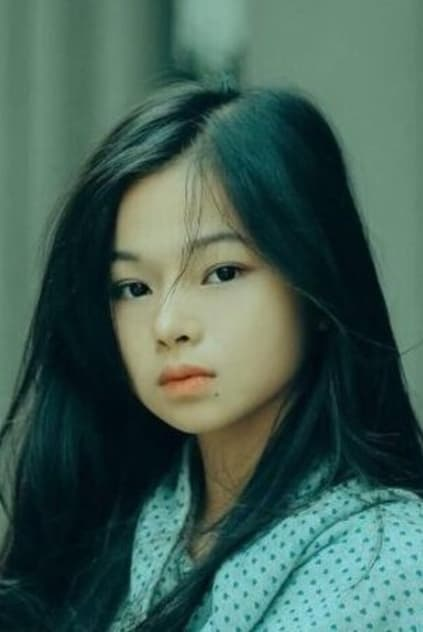

In [227]:
celeb_faces_test[0]['image']

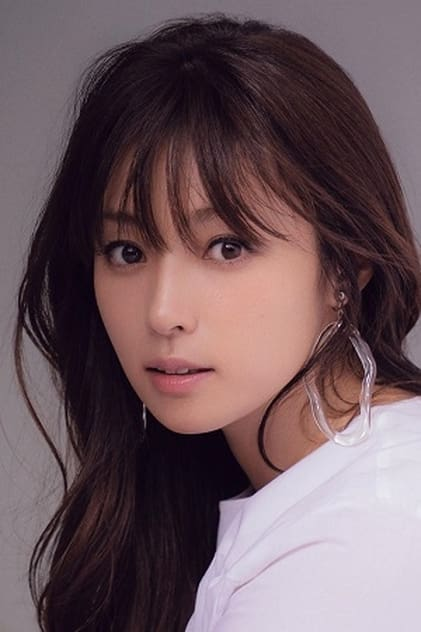

In [233]:
celeb_faces_test[1408]['image']